<a href="https://colab.research.google.com/github/mdjamina/M1_TALA410A_NLP_PS1/blob/main/projet_bdd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sqlite3
import csv
import pprint as pp
import pandas as pd
import re
import random
import numpy as np

# Partie 1: 

## Extraction du fichier CSV

In [ ]:
df = pd.read_csv('./data_client.csv',dtype=str)

df.head()



## Transformation des données

### Découpage de la colonne 'NOM_CLIENT'

Dans le fichier source le champs NOM_CLIENT, le nom et le prénom concaténés 

In [ ]:
df[['Nom','Prenom']] = df.NOM_CLIENT.str.split(" ",expand=True,)

df[['ID_CLIENT','NOM_CLIENT','Nom','Prenom']].head()

### Contrôle du champs 'EMAIL' 

Ajouter le champs 'Valid_Email' pour rejeter les emails non valides

In [ ]:
regex = r'\b[A-Za-z0-9._-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'

df[['Valid_Email']] = df.EMAIL.str.match(regex)

Suppresion des lignes non valide

In [ ]:
# selecting rows based on condition
df = df.drop(df[df['Valid_Email'] == False].index)


### Gestion des doublons

In [ ]:
#suppresion des doublons
df_doublon = df.drop_duplicates(subset=['ID_CLIENT'],keep = False, inplace = True)


## Chargement de la BDD

### Connexion à la bdd

In [ ]:

bdd_conn = sqlite3.connect("/content/agence_de_voyage.db")
bdd_conn.text_factory = str 
cursor = bdd_conn.cursor()

### Initialisation des tables cibles

In [ ]:
cursor.execute('DELETE FROM Client')
bdd_conn.commit()

### Alimentation de la table:  ***Client***

In [ ]:
query = """
 insert into Client (
   id_client 
   , nom_client 
   , prenom_client 
   , date_naissance
   ,email	
   , adresse_postale 
   , code_postal	
   , ville	
   , pays 
   , num_telephone
   )
  values (
     ? 
   , ? 
   , ? 
   , ?
   , ?	
   , ? 
   , ?	
   , ?	
   , ? 
   , ?
  )
 """

In [ ]:
colms = ['ID_CLIENT', 'Nom', 'Prenom', 'DATE_NAIS', 'EMAIL',
       'ADDRESS', 'CODE_POSTAL', 'VILLE', 'PAYS' , 'TEL'
       ]
count=0
for i,row in df[colms].iterrows():
  cursor.execute(query,tuple([*(row)]))
  count+=1

print('Nombre d''insertion {} ligne(s)'.format(count))
bdd_conn.commit()

Nombre dinsertion 3674


In [ ]:
query = """
SELECT  count(*)
FROM Client

"""

cursor.execute(query)

cursor.fetchall()

[(3674,)]

In [ ]:
bdd_conn.close()

# Partie 2

In [ ]:

bdd_conn = sqlite3.connect("/content/agence_de_voyage.db")
bdd_conn.text_factory = str 
cursor = bdd_conn.cursor()

In [ ]:
query = """
select c.id_client, c.nom_client,c.prenom_client
,COUNT(*) as nb_reservation,SUM(t.prix_transport) as total_paiement
from client c
INNER JOIN Reservation_Transport rt on c.id_client = rt.id_client
INNER JOIN transport t on rt.id_transport = t.id_transport 
GROUP BY c.id_client, c.nom_client,c.prenom_client;
"""
cursor.execute(query)
 
df = pd.DataFrame(cursor.fetchall(), columns = ('id_client', 'nom_client', 'prenom_client'
, 'nb_reservation','total_paiement'))

df

,id_client,nom_client,prenom_client,nb_reservation,total_paiement
0,29378,Kassovitz,Mathieu,2,386
1,73382,Potter,Harry,2,319
2,73834,Tu,Justine,4,1855
3,73835,Piter,Kenza,2,875


In [ ]:
# Extraction du chiffre d'affaire/10K€ mensuel

query = """
SELECT strftime('%Y',date_res) as annee, SUM(montant) AS CA
FROM(
select rt.idReservationTransport as id_RES, RT.id_client, DATE(t.date_depart) as date_res, t.prix_transport as montant, 'TRANSPORT' as type_res
from Reservation_Transport as rt
inner JOIN transport t on rt.id_transport = t.id_transport
UNION
select ra.idReservationActivite as id_RES, RA.id_client , DATE(ra.date_debut) as date_res,p.prix_programme as montant, 'ACTIVITES' as type_res
from Reservation_Activite as ra
inner join Programme p on ra.id_activite = p.id_programme
UNION
select rh.idReservationHotel as id_RES, RH.id_client, DATE(rh.date_checkin)as date_res, h.prix_hebergement as montant, 'HOTEL' as type_res
from Reservation_Hotel as rh
inner join Hebergement h on rh.id_hotel= h.id_hebergement) DATA
GROUP BY strftime('%Y',date_res)
"""

cursor.execute(query)

df = pd.DataFrame(cursor.fetchall(), columns = ('id_res','id_client', 'dat_res', 'montant', 'type_res'))


df

,id_res,id_client,dat_res,montant,type_res
0,293,73835,2022-10-16,50,ACTIVITES
1,912,73834,2022-10-14,30,ACTIVITES
2,991,29378,2022-10-17,30,ACTIVITES
3,1234,73835,2022-11-14,425,TRANSPORT
4,1235,73835,2022-10-21,450,TRANSPORT
5,1236,73382,2022-10-15,100,TRANSPORT
6,1237,73382,2022-10-20,219,TRANSPORT
7,1238,73834,2022-10-09,755,TRANSPORT
8,1239,73834,2022-10-10,300,TRANSPORT
9,1240,73834,2021-10-19,300,TRANSPORT


In [ ]:
#Extraction du chiffre d'affaire/10K€ mensuel 
query = """
SELECT strftime('%Y',date_res) as annee, SUM(montant) AS CA
FROM(
select rt.idReservationTransport as id_RES, RT.id_client
, DATE(t.date_depart) as date_res, t.prix_transport as montant
, 'TRANSPORT' as type_res
from Reservation_Transport as rt
inner JOIN transport t on rt.id_transport = t.id_transport
UNION
select ra.idReservationActivite as id_RES, RA.id_client 
, DATE(ra.date_debut) as date_res,p.prix_programme as montant
, 'ACTIVITES' as type_res
from Reservation_Activite as ra
inner join Programme p on ra.id_activite = p.id_programme
UNION
select rh.idReservationHotel as id_RES, RH.id_client, DATE(rh.date_checkin)as date_res
, h.prix_hebergement as montant, 'HOTEL' as type_res
from Reservation_Hotel as rh
inner join Hebergement h on rh.id_hotel= h.id_hebergement) DATA
GROUP BY strftime('%Y',date_res)
"""

cursor.execute(query)

df = pd.DataFrame(cursor.fetchall(), columns = ('Annee','CA'),)


df = df.set_index('Annee')

df.plot.bar()



In [ ]:
#Extraction du chiffre d'affaire/10K€ mensuel pour l'année 2021​
query = """
SELECT strftime('%Y-%m',date_res) as Mois, SUM(montant)/10000 AS CA
FROM(
select rt.idReservationTransport as id_RES, RT.id_client, DATE(t.date_depart) as date_res, t.prix_transport as montant, 'TRANSPORT' as type_res
from Reservation_Transport as rt
inner JOIN transport t on rt.id_transport = t.id_transport
UNION
select ra.idReservationActivite as id_RES, RA.id_client , DATE(ra.date_debut) as date_res,p.prix_programme as montant, 'ACTIVITES' as type_res
from Reservation_Activite as ra
inner join Programme p on ra.id_activite = p.id_programme
UNION
select rh.idReservationHotel as id_RES, RH.id_client, DATE(rh.date_checkin)as date_res, h.prix_hebergement as montant, 'HOTEL' as type_res
from Reservation_Hotel as rh
inner join Hebergement h on rh.id_hotel= h.id_hebergement) DATA
where strftime('%Y',date_res) = '2021'
GROUP BY strftime('%Y-%m',date_res) 
"""

cursor.execute(query)
df = DataFrame(cursor.fetchall(), columns = ('Mois','CA'))
df = df.set_index('Mois')
df.plot.bar()



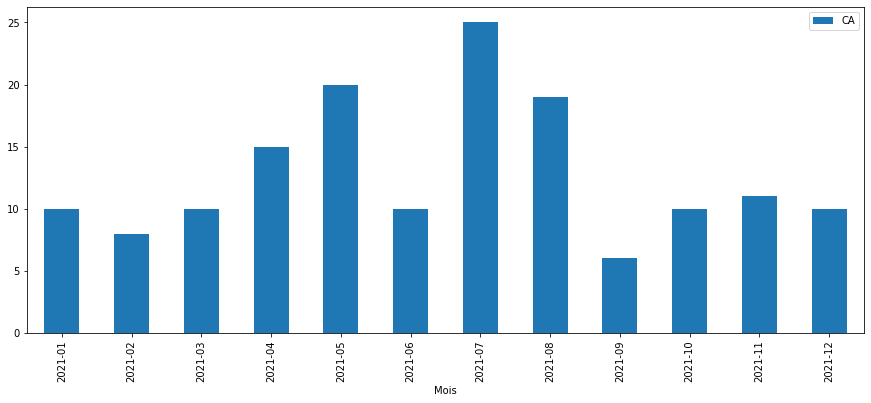

In [ ]:
#demo :Répartition du nombre des réservations par activités pour l’année 2021
query = """
SELECT  Mois,  CA
FROM(
SELECT '2021-12'AS MOIS, 10 AS CA
UNION
SELECT '2021-11'AS MOIS, 11 AS CA
UNION
SELECT '2021-10'AS MOIS, 10 AS CA
UNION
SELECT '2021-09'AS MOIS, 6 AS CA
UNION
SELECT '2021-08'AS MOIS, 19 AS CA
UNION
SELECT '2021-07'AS MOIS, 25 AS CA
UNION
SELECT '2021-06'AS MOIS, 10 AS CA
UNION
SELECT '2021-05'AS MOIS, 20 AS CA
UNION
SELECT '2021-04'AS MOIS, 15 AS CA
UNION
SELECT '2021-03'AS MOIS, 10 AS CA
UNION
SELECT '2021-02'AS MOIS, 8 AS CA
UNION
SELECT '2021-01'AS MOIS, 10 AS CA

) 
"""

cursor.execute(query)

df = pd.DataFrame(cursor.fetchall(), columns = ('Mois','CA'))


df = df.set_index('Mois')



df.plot.bar(figsize=(15, 6))



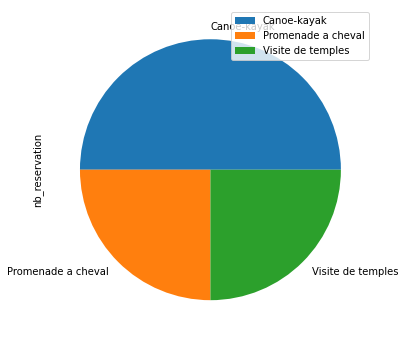

In [ ]:
#Répartition du nombre des réservations par activités pour l’année 2021
query = """
select p.nom as activite, count(*) as nb_reservation
from Reservation_Activite as ra
inner join Programme p on ra.id_activite = p.id_programme
where strftime('%Y',ra.date_debut) = '2021'
group by nom
"""

cursor.execute(query)

df = DataFrame(cursor.fetchall(), columns = ('activite','nb_reservation'))
df = df.set_index('activite')
df.plot.pie(y='nb_reservation',figsize=(6, 6));



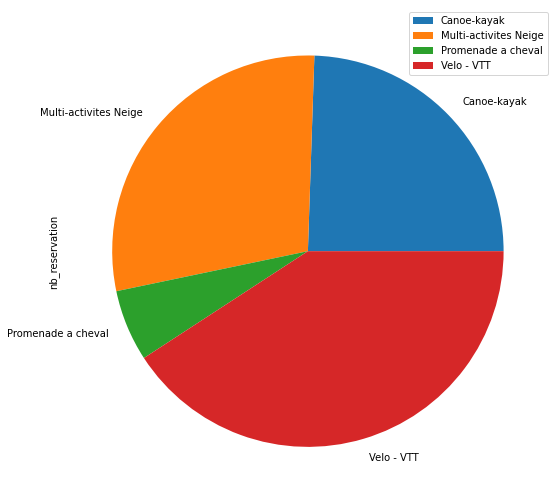

In [ ]:
#demo
query = """
select nom, nb_reservation
FROM(
select 'Canoe-kayak' as nom, 2244 as nb_reservation
union
select 'Promenade a cheval' as nom , 542 as nb_reservation
union
select 'Velo - VTT' as nom , 3742 as nb_reservation
union
select 'Multi-activites Neige' as nom , 2642 as nb_reservation)
"""

cursor.execute(query)

df = pd.DataFrame(cursor.fetchall(), columns = ('activite','nb_reservation'))


df = df.set_index('activite')



df.plot.pie(y='nb_reservation',figsize=(9, 9));

In [ ]:
bdd_conn.close()